This notebook takes the files that were not used to create the word list in the find_words notebook and vectorizes them so they can be fed through models. Still working on a way to effectively safe this numerical data, but I may only be able to do that with binary data.

In [1]:
import os
import json
import numpy as np
import pandas as pd
import pyarrow as pa
from pandas.io.json import json_normalize
import cryptography
import re
from cryptography.fernet import Fernet
import bs4
from nltk.tokenize import word_tokenize
from nltk.metrics import edit_distance
import pickle
from collections import Counter

In [2]:
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
def tokenize(text):
    text = re.sub('&quot;','\'',text)
    text = re.sub('&amp;','&',text)
    text = re.sub('"', '', text)
    text = re.sub(r'\'(?!\')(.*)\'',r'\0', text)
    
    toks = re.split(r'[\s,:;{}\(\)<>\/�]+',text.lower())
    return sorted(toks)

In [3]:
vocab = [a for a,b in load_obj('sorted_kvpairs_url')]
vocab = sorted(vocab[:10000])#takes the top 10000 by freq and puts them in alphabetical/ascii order

In [4]:
# Create corpus
data = []
labels = []
indicators=[]
url= []
url_to_ind_distance = []
text_len = []
# Not included as all their files seem to be empty or they have no enrichment: 
    #4/5, 4/6, 4/13, 4/14, 4/15, 4/31, 5/13, 5/14, 5/15, 5/16, 5/17, 5/18, 7/4, 7/5, 7/6
# Empty List serves as a place holder between the data used in find_words and the test data I'm using here
date_batches = [['newbenigndata'],['2019-04-22','2019-04-23','2019-04-24','2019-04-25','2019-04-26','2019-04-27','2019-04-28','2019-04-29'],
                ['2019-04-11','2019-04-12','2019-04-16','2019-04-17','2019-04-18','2019-04-19','2019-04-20','2019-04-21'],
                ['2019-04-30','2019-05-01','2019-05-02','2019-05-03','2019-05-04'],
                ['2019-05-05','2019-05-06','2019-05-07','2019-05-08','2019-05-09','2019-05-10','2019-05-11','2019-05-12'],
                ['2019-05-19','2019-05-20'],
                ['2019-05-21','2019-05-22','2019-05-23','2019-05-24','2019-05-25','2019-05-26','2019-05-27','2019-05-28'],
                ['2019-05-29','2019-05-30','2019-05-31','2019-06-01','2019-06-02','2019-06-03','2019-06-04','2019-06-05'],
                ['2019-06-06','2019-06-07','2019-06-08','2019-06-09','2019-06-10','2019-06-11','2019-06-12','2019-06-13'],[],
                ['2019-06-14', '2019-06-15','2019-06-16', '2019-06-17','2019-06-18','2019-06-19', '2019-06-20', '2019-06-21'],
                ['2019-06-22', '2019-06-23', '2019-06-25', '2019-06-26', '2019-06-27', '2019-06-28','2019-06-29', '2019-06-30'],
                ['2019-07-01','2019-07-02', '2019-07-03', '2019-07-07'],
                ['newNONTORbenigndata']]
dates = date_batches[-1]+date_batches[-2]+date_batches[-3]+date_batches[-4]#+date_batches[3]+date_batches[4]+date_batches[5]+date_batches[6]+date_batches[7]+date_batches[8] 
#'2019-04-12','2019-04-16','2019-04-17','2019-04-18','2019-04-19','2019-04-20','2019-04-21]
for date in dates:
    files = os.listdir('/data/data/'+date+'/enrichment/fetch_page')
    top = len(files)
    if top > 70:
        top = 70
    for j in range(top):
        with open('/data/data/'+date+'/enrichment/fetch_page/'+files[j]) as d:
            r = json.load(d)
            try:
                df = json_normalize(r['data'])
            except:
                break
        try:
            df = df[df['status_code'] == 200].reset_index(drop=True)
        except:
            df = df[df['success']]
        #Need to determine label
        html_str = df['page_content'].copy()
        
        for i in range(len(html_str)):
            if df.loc[i,'url'] in url:
                continue
            else:
                url.append(df.loc[i, 'url'])
            if len(files[j]) > 10:
                labels += [1]
            else:
                labels += [0]
            key = bytes( df.loc[i,'encryption_key'],encoding = 'UTF-8')
            f = Fernet(key) 
            #decrypt string
            text = f.decrypt(bytes(html_str[i],encoding='UTF-8'))
            #clean out html
            text = text.decode('utf8')
            text_len.append(len(text))
            url_to_ind_distance.append(edit_distance(df.loc[i,'url'],df.loc[i,'indicator']))

            toks = tokenize(text)
            #need to create vector 
            count = Counter()
            for tok in toks:
                count[tok] += 1
            vec = []
            for v in vocab:
                vec = np.append(vec, [count[v]])
            data.append(vec)
                
            
            
         #end of for
    #end of for
    print('------------'+date+'---------------')
#end of for
data = np.row_stack(data)
data[:2]

------------newNONTORbenigndata---------------
------------2019-07-01---------------
------------2019-07-02---------------
------------2019-07-03---------------
------------2019-07-07---------------
------------2019-06-22---------------
------------2019-06-23---------------
------------2019-06-25---------------
------------2019-06-26---------------
------------2019-06-27---------------
------------2019-06-28---------------
------------2019-06-29---------------
------------2019-06-30---------------
------------2019-06-14---------------
------------2019-06-15---------------
------------2019-06-16---------------
------------2019-06-17---------------
------------2019-06-18---------------
------------2019-06-19---------------
------------2019-06-20---------------
------------2019-06-21---------------


array([[3., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [67]:
#stick the labels on to make sure they stay properly matched as I turn data into a DataFrame for shuffling and balancing
print(data.shape)
np.column_stack([data,labels]).shape

(4589, 10000)


(4589, 10001)

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [102]:
X = pd.DataFrame( data,columns=vocab)#np.column_stack([data,labels])
X['url_to_ind'] = url_to_ind_distance
X['text_len'] = text_len
X['unsafe'] = labels
X = X.drop_duplicates()
X1 = X[X['unsafe']==1].sample(frac=1)
print(X1.shape)
X0 = X[X['unsafe']==0].sample(frac=1)
print(X0.shape)
if(X0.shape[0] < X1.shape[0]):
    X1 = X1.reset_index(drop=True).loc[:(X0.shape[0]),:]
else: 
    X0 = X0.reset_index(drop=True).loc[:(X1.shape[0]),:]
print(X1.shape)
print(X0.shape)
temp_df = pd.concat([X0,X1]).sample(frac=1)
X = temp_df.drop(columns=['unsafe'])
Y = temp_df['unsafe']

(1711, 10003)
(2261, 10003)
(1711, 10003)
(1712, 10003)


In [105]:
#X = data
#Y = labels
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size= 0.6, test_size=0.4)
forest = RandomForestClassifier(n_estimators=80)
forest.fit(X_train,Y_train)
print()
print(forest.score(X_test,Y_test))
print(*(sorted(list(zip(vocab,forest.feature_importances_)), key=lambda x: x[1],reverse=True))[:100], sep = '\n')
print(classification_report(Y_test,forest.predict(X_test)))

#forest = RandomForestRegressor(n_estimators=80,random_state=13)
#forest.fit(X_train,Y_train)
#print(forest.score(X_test,Y_test))
#print(*(sorted(list(zip(vocab,forest.feature_importances_)), key=lambda x: x[1],reverse=True))[:100], sep = '\n')



0.7956204379562044
('script', 0.013565347095304641)
('meta', 0.009802154467416684)
('a', 0.008024725534680064)
('function', 0.00783414945850082)
('div', 0.007069130298423087)
('target=_blank', 0.006573250150978455)
('s', 0.005870086403634259)
('img', 0.005797029494810169)
('href=https', 0.005655468018594915)
('name=keywords', 0.005588757629589856)
('new', 0.005530736712598492)
('li', 0.005476396168960012)
('rel=stylesheet', 0.005230383715202424)
('[0]', 0.005133533066287969)
('javascript', 0.004997478263105494)
('news', 0.004958243150430527)
('1', 0.004196207535283486)
('arguments', 0.003456885142350018)
('href=http', 0.003334610453732152)
('type=text', 0.0032777175979914392)
('event', 0.003080532639160124)
('user', 0.0030583767006813417)
('favicon.ico', 0.003058203777505793)
('link', 0.002984832700592136)
('twitter.com', 0.002972948778828304)
('else', 0.0029537511845318942)
('null', 0.002813971133442428)
('\x00', 0.0027961644690243093)
('var', 0.002765855504332458)
('in', 0.002707553

In [106]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=13)
clf.fit(X_train,Y_train)
print(clf.score(X_test,Y_test))
print(classification_report(Y_test,clf.predict(X_test)))

0.7832116788321168
             precision    recall  f1-score   support

          0       0.80      0.75      0.78       688
          1       0.77      0.81      0.79       682

avg / total       0.78      0.78      0.78      1370



In [109]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(verbose=True, batch_size= 9, random_state = 15)
clf.fit(X_train,Y_train)
print(clf.score(X_test,Y_test))
print(classification_report(Y_test,clf.predict(X_test)))

Iteration 1, loss = 8.73688905
Iteration 2, loss = 5.96237829
Iteration 3, loss = 3.74173931
Iteration 4, loss = 3.35131648
Iteration 5, loss = 4.23664669
Iteration 6, loss = 3.65870737
Iteration 7, loss = 5.34645568
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
0.6620437956204379
             precision    recall  f1-score   support

          0       0.61      0.93      0.73       688
          1       0.85      0.39      0.54       682

avg / total       0.73      0.66      0.64      1370



In [110]:
clf = MLPClassifier(verbose=True, batch_size= 9, random_state = 13)
clf.fit(X_train,Y_train)
print(clf.score(X_test,Y_test))
print(classification_report(Y_test,clf.predict(X_test)))

Iteration 1, loss = 7.29881352
Iteration 2, loss = 7.10488683
Iteration 3, loss = 4.75932864
Iteration 4, loss = 3.59717582
Iteration 5, loss = 3.20208511
Iteration 6, loss = 4.80790429
Iteration 7, loss = 3.94758288
Iteration 8, loss = 4.19771202
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
0.7532846715328467
             precision    recall  f1-score   support

          0       0.71      0.85      0.78       688
          1       0.81      0.66      0.73       682

avg / total       0.76      0.75      0.75      1370



In [111]:
from sklearn.neural_network import MLPClassifier
for i in range(0,30):
    X = pd.DataFrame( data,columns=vocab)#np.column_stack([data,labels])
    X['url_to_ind'] = url_to_ind_distance
    X['text_len'] = text_len
    X['unsafe'] = labels
    X = X.drop_duplicates()
    X1 = X[X['unsafe']==1].sample(frac=1)
    X0 = X[X['unsafe']==0].sample(frac=1)
    if(X0.shape[0] < X1.shape[0]):
        X1 = X1.reset_index(drop=True).loc[:(X0.shape[0]),:]
    else: 
        X0 - X0.reset_index(drop=True).loc[:(X1.shape[0]),:]
    temp_df = pd.concat([X0,X1]).sample(frac=1) 
    X = temp_df.drop(columns=['unsafe'])
    Y = temp_df['unsafe']
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size= 0.5, test_size=0.5, random_state=10*i)
    clf = MLPClassifier(batch_size= 9, random_state = i)
    clf.fit(X_train,Y_train)
    print(clf.score(X_test,Y_test))
    #print(classification_report(Y_test,clf.predict(X_test)))

0.7542799597180262
0.771399798590131
0.7900302114803626
0.7537764350453172
0.8081570996978852
0.7804632426988922
0.7719033232628398
0.7754279959718026
0.7779456193353474
0.5140986908358509
0.622356495468278
0.7829808660624371
0.7829808660624371
0.797079556898288
0.7865055387713998
0.6389728096676737
0.607754279959718
0.43303121852970794
0.7109768378650554
0.6178247734138973
0.7804632426988922
0.7739174219536757
0.7537764350453172
0.7819738167170192
0.7774420946626385
0.7925478348439073
0.7804632426988922
0.6430010070493454
0.7824773413897281
0.7099697885196374


In [83]:
#get new X and Y
X = pd.DataFrame( data,columns=vocab)#np.column_stack([data,labels])
X['url_to_ind'] = url_to_ind_distance
X['text_len'] = text_len
X['unsafe'] = labels
X = X.drop_duplicates()
X1 = X[X['unsafe']==1].sample(frac=1)
X0 = X[X['unsafe']==0].sample(frac=1)
if(X0.shape[0] < X1.shape[0]):
    X1 = X1.reset_index(drop=True).loc[:(X0.shape[0]),:]
else: 
    X0 - X0.reset_index(drop=True).loc[:(X1.shape[0]),:]
temp_df = pd.concat([X0,X1]).sample(frac=1).drop_duplicates() 
X = temp_df.drop(columns=['unsafe'])
Y = temp_df['unsafe']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size= 0.60, test_size=0.40)

Working with Keras to try and improve on this 86-88% accuracy

In [84]:
from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(layers.Dense(12, input_dim=X_train.shape[1], activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_115 (Dense)            (None, 12)                120036    
_________________________________________________________________
dense_116 (Dense)            (None, 1)                 13        
Total params: 120,049
Trainable params: 120,049
Non-trainable params: 0
_________________________________________________________________


In [113]:
model = Sequential()
model.add(layers.Dense(40, input_dim=X_train.shape[1], activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(10, input_dim=X_train.shape[1], activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train,Y_train, epochs=130, verbose=1, validation_data=(X_test,Y_test), batch_size=10)
loss, accuracy = model.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))



Train on 1986 samples, validate on 1986 samples
Epoch 1/130
1986/1986 [==============================] - 4s 2ms/step - loss: 1.1553 - acc: 0.5257 - val_loss: 0.6906 - val_acc: 0.5650
Epoch 2/130
1986/1986 [==============================] - 2s 782us/step - loss: 0.7268 - acc: 0.5725 - val_loss: 0.6875 - val_acc: 0.5650
Epoch 3/130
1986/1986 [==============================] - 2s 774us/step - loss: 0.7772 - acc: 0.5715 - val_loss: 0.6861 - val_acc: 0.5650
Epoch 4/130
1986/1986 [==============================] - 2s 776us/step - loss: 0.7825 - acc: 0.5725 - val_loss: 0.6853 - val_acc: 0.5650
Epoch 5/130
1986/1986 [==============================] - 2s 774us/step - loss: 0.7281 - acc: 0.5755 - val_loss: 0.6849 - val_acc: 0.5650
Epoch 6/130
1986/1986 [==============================] - 2s 782us/step - loss: 0.7123 - acc: 0.5725 - val_loss: 0.6847 - val_acc: 0.5650
Epoch 7/130
1986/1986 [==============================] - 2s 776us/step - loss: 0.7205 - acc: 0.5735 - val_loss: 0.6847 - val_acc: 0.

1986/1986 [==============================] - 2s 775us/step - loss: 0.6874 - acc: 0.5846 - val_loss: 0.6867 - val_acc: 0.5710
Epoch 120/130
1986/1986 [==============================] - 2s 782us/step - loss: 0.7419 - acc: 0.5821 - val_loss: 0.6861 - val_acc: 0.5710
Epoch 121/130
1986/1986 [==============================] - 2s 779us/step - loss: 0.6827 - acc: 0.5836 - val_loss: 0.6860 - val_acc: 0.5715
Epoch 122/130
1986/1986 [==============================] - 2s 778us/step - loss: 0.6741 - acc: 0.5836 - val_loss: 0.6858 - val_acc: 0.5720
Epoch 123/130
1986/1986 [==============================] - 2s 778us/step - loss: 0.6812 - acc: 0.5866 - val_loss: 0.6865 - val_acc: 0.5710
Epoch 124/130
1986/1986 [==============================] - 2s 776us/step - loss: 0.6755 - acc: 0.5841 - val_loss: 0.6866 - val_acc: 0.5710
Epoch 125/130
1986/1986 [==============================] - 2s 779us/step - loss: 0.6734 - acc: 0.5841 - val_loss: 0.6864 - val_acc: 0.5705
Epoch 126/130
1986/1986 [================

In [182]:
#tr_acc = []
#te_acc = []
tr_acc20 = []
te_acc20 = []
d_lays = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]

In [188]:
for d in d_lays:
    model = Sequential()
    model.add(layers.Dense(d, input_dim=X_train.shape[1], activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss=, optimizer='adagrad', metrics=['accuracy'])
    history = model.fit(X_train,Y_train, epochs=20, verbose=1, validation_data=(X_test,Y_test), batch_size=10)
    loss, accuracy = model.evaluate(X_train, Y_train, verbose=False)
    tr_acc5 = tr_acc5 +[accuracy]
    print("Training Accuracy: {:.4f}".format(accuracy))
    loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
    te_acc5 = te_acc5 +[accuracy]
    print("Testing Accuracy:  {:.4f}".format(accuracy))

Train on 2227 samples, validate on 1486 samples
Epoch 1/20
2227/2227 [==============================] - 13s 6ms/step - loss: 0.7549 - acc: 0.6057 - val_loss: 0.6707 - val_acc: 0.6265
Epoch 2/20
2227/2227 [==============================] - 1s 384us/step - loss: 0.6344 - acc: 0.6466 - val_loss: 0.6670 - val_acc: 0.6406
Epoch 3/20
2227/2227 [==============================] - 1s 387us/step - loss: 0.6191 - acc: 0.6587 - val_loss: 0.6606 - val_acc: 0.6413
Epoch 4/20
2227/2227 [==============================] - 1s 389us/step - loss: 0.6124 - acc: 0.6753 - val_loss: 0.6562 - val_acc: 0.6534
Epoch 5/20
2227/2227 [==============================] - 1s 386us/step - loss: 0.5995 - acc: 0.6879 - val_loss: 0.6556 - val_acc: 0.6541
Epoch 6/20
2227/2227 [==============================] - 1s 387us/step - loss: 0.5898 - acc: 0.6960 - val_loss: 0.6626 - val_acc: 0.6588
Epoch 7/20
2227/2227 [==============================] - 1s 387us/step - loss: 0.5874 - acc: 0.6996 - val_loss: 0.6738 - val_acc: 0.6581
E

KeyboardInterrupt: 

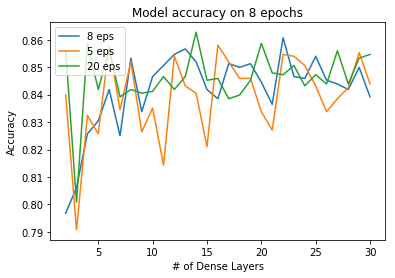

In [196]:
plt.plot(d_lays[1:],te_acc[1:])
plt.plot(d_lays[1:],te_acc5[1:30])
plt.plot(d_lays[1:],te_acc5[31:-6])
plt.title('Model accuracy on 8 epochs')
plt.ylabel('Accuracy')
plt.xlabel('# of Dense Layers')
plt.legend(['8 eps', '5 eps','20 eps'], loc='upper left')
plt.show()